In [97]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import csr_matrix, diags



In [156]:
# load data
rawData = pd.read_csv("truth_seeker.csv")

rawData.rename(columns={'Unnamed: 0': 'ind'}, inplace=True)

rawData.shape # (134198, 9)
rawData.columns # 'ind', 'author', 'statement', 'target', 'BinaryNumTarget',
    # 'manual_keywords', 'tweet', '5_label_majority_answer',
    # '3_label_majority_answer'
    


Index(['ind', 'author', 'statement', 'target', 'BinaryNumTarget',
       'manual_keywords', 'tweet', '5_label_majority_answer',
       '3_label_majority_answer'],
      dtype='object')

In [158]:
def determine_outcome(row):
    if (row['target'] == True and row['3_label_majority_answer'] == 'Agree') or (row['target'] == False and row['3_label_majority_answer'] == 'Disagree'):
        return 'real'
    elif (row['target'] == True and row['3_label_majority_answer'] == 'Disagree') or (row['target'] == False and row['3_label_majority_answer'] == 'Agree'):
        return 'fake'
    else:
        return None

rawData['outcome'] = rawData.apply(determine_outcome, axis=1)
smallData = rawData.sample(frac=0.01, random_state=40)
reshaped = smallData[smallData['outcome'].notnull()]
reshaped['outcome'].value_counts() # fake: 65213, real: 68985

outcome
real    698
fake    644
Name: count, dtype: int64

In [159]:
newTweets = pd.read_csv("new_tweets.csv")

subset_data_without_new = reshaped.copy()

newTweets['3_label_majority_answer'] = newTweets['3_label_majority_answer'].astype(str)

subset_data = pd.concat([reshaped, newTweets], ignore_index=True)

In [160]:
subset_data.shape # (1485, 16)

(1485, 16)

In [161]:
topics_list = [topic.split('nn') for topic in subset_data['tweet'].astype(str)]
topics_list = [[topic.replace('^.* -', '') for topic in topics] for topics in topics_list]
topics_unique = sorted(set([item for sublist in topics_list for item in sublist]))


In [162]:
# dummy matrix
topics_dummies = [[topic in topics for topic in topics_unique] for topics in topics_list]
topics_dummies = csr_matrix(topics_dummies)

In [163]:
topics_dummies.shape # (1485, 1725)

(1485, 1725)

In [164]:
# labelling for ease
texts = {index: text for index, text in zip(subset_data['ind'], subset_data['tweet'])}

In [165]:
# building corpus
corpus = list(texts.values())

# corpus cleaning
vectorizer = CountVectorizer(strip_accents='unicode', stop_words='english', lowercase=True, token_pattern=r'\b[a-zA-Z]{3,}\b')
dtm_slam = vectorizer.fit_transform(corpus)

In [166]:
# row names
dtm_slam.index = subset_data['ind']

In [167]:
# dropping terms that occur in <3 documents
drop = dtm_slam.sum(axis=0).A1 < 3
dtm_slam = dtm_slam[:, ~drop]

dtm_slam.shape

(1485, 2074)

In [168]:
# converting to sparse matrix for memory/performance
dtm = csr_matrix(dtm_slam)

In [169]:
# normalizing (preferred)
dtm_norm = diags(1 / dtm.sum(axis=1).A1) @ dtm
dtm_norm.index = subset_data['ind']

In [170]:
# summary statistics
print("DTM:")
print(f"Mean entry: {dtm_norm.mean()}")
print(f"Dimensions: {dtm_norm.shape}")

DTM:
Mean entry: 0.00048216007714561236
Dimensions: (1485, 2074)


In [171]:
subset_data_without_new = reshaped.copy()
train_dtm = dtm[dtm_norm.index.isin(subset_data_without_new['ind'])]
train_dtm.shape # (1485, 1725)

(1342, 2074)

In [172]:
subset_row_names = subset_data_without_new['ind'].astype(str)
new_dtm = dtm[~dtm_norm.index.isin(subset_data_without_new['ind'])]

In [173]:
new_dtm.shape # (143, 1725)

(143, 2074)

In [175]:
label_counts = rawData['outcome'].value_counts()

proportion_fake = label_counts['fake'] / label_counts.sum()
proportion_real = label_counts['real'] / label_counts.sum()

print(f"Full original data set proportion fake: {proportion_fake}")
print(f"Full original data set proportion real: {proportion_real}")

Full original data set proportion fake: 0.4859461392867256
Full original data set proportion real: 0.5140538607132744


In [177]:
training_label_counts = subset_data['outcome'].value_counts()
training_prop_fake = training_label_counts['fake'] / training_label_counts.sum()
training_prop_real = training_label_counts['real'] / training_label_counts.sum()

print(f"Training data set proportion fake: {training_prop_fake}")
print(f"Training data set proportion real: {training_prop_real}")

Training data set proportion fake: 0.4855218855218855
Training data set proportion real: 0.5144781144781144


In [178]:
new_label_counts = newTweets['outcome'].value_counts()
new_prop_fake = new_label_counts['fake'] / new_label_counts.sum()
new_prop_real = new_label_counts['real'] / new_label_counts.sum()

print(f"New data set proportion fake: {new_prop_fake}")
print(f"New data set proportion real: {new_prop_real}")

New data set proportion fake: 0.5384615384615384
New data set proportion real: 0.46153846153846156


# done w preprocessing

In [179]:
import numpy as np
from scipy.sparse import diags
np.random.seed(2024)


In [181]:
norm_train_dtm = diags(1 / train_dtm.sum(axis=1).A1) @ train_dtm
norm_train_dtm.index = subset_data_without_new['ind']
train_dtm = norm_train_dtm


In [183]:

# split into train and test datasets
total_documents = train_dtm.shape[0]
train_size = round(0.8 * total_documents)
test_size = total_documents - train_size

train_indices = np.random.choice(total_documents, train_size, replace=False)
dtm_train = train_dtm[train_indices]

test_indices = np.setdiff1d(np.arange(total_documents), train_indices)
dtm_test = train_dtm[test_indices]

print(dtm_train.shape)
print(dtm_test.shape)

(1074, 2074)
(268, 2074)


In [186]:
train_doc_ids = train_indices.tolist()
test_doc_ids = test_indices.tolist()

# actual classification for training data
train_rows = rawData.loc[train_doc_ids]
test_rows = rawData.loc[test_doc_ids]

In [189]:
train_actual_classifications = rawData.loc[train_doc_ids].copy()
train_actual_classifications['outcome'] = train_actual_classifications['outcome'].map({'fake': 0, 'real': 1})
train_actual_classifications = train_actual_classifications['outcome'].values

In [198]:
X = dtm_train.toarray()
y = train_actual_classifications

In [199]:
# true classification for TRUTHSEEKERS test data
test_actual_classifications = rawData.loc[test_doc_ids].copy()
test_actual_classifications['outcome'] = test_actual_classifications['outcome'].map({'fake': 0, 'real': 1})
test_actual_classifications = test_actual_classifications['outcome'].values

In [200]:

X_test = dtm_test.toarray()
y_test = test_actual_classifications

In [201]:
# true classification for newTweets data
newTweets_classifications = newTweets.copy()
newTweets_classifications['outcome'] = newTweets_classifications['outcome'].map({'fake': 0, 'real': 1})
newTweets_classifications = newTweets_classifications['outcome'].values

X_newTweets = new_dtm.toarray()
y_newTweets = newTweets_classifications

# LASSO

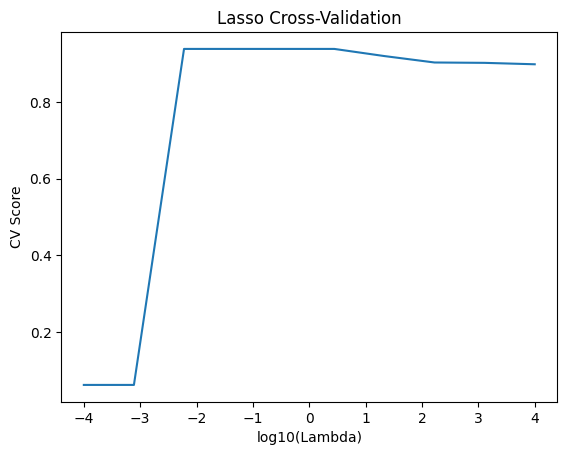

Best lambda: 0.005994842503189409


In [206]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2018)

complete_cases = np.all(np.isfinite(X) & np.isfinite(y.reshape(-1, 1)), axis=1)
X_complete = X[complete_cases]
y_complete = y[complete_cases]

# Perform cross-validation
cv = KFold(n_splits=10)
lasso = LogisticRegressionCV(penalty='l1', solver='liblinear', cv=cv, scoring='accuracy', max_iter=10000)

lasso.fit(X_complete, y_complete)

cv_scores = lasso.scores_[1].mean(axis=0)
log_lambdas = np.log10(lasso.Cs_)

best_lambda_index = np.argmax(cv_scores)
best_lambda = lasso.Cs_[best_lambda_index]

plt.plot(log_lambdas, cv_scores)
plt.xlabel("log10(Lambda)")
plt.ylabel("CV Score")
plt.title("Lasso Cross-Validation")
plt.show()

print(f"Best lambda: {best_lambda}")